In [1]:
import numpy as np
import pandas as pd
import glob
from model.ctabgan import CTABGAN
df = pd.read_csv("Real_Datasets/adult.csv")
#df = df.drop(columns=['Year','Model'])
df = df[['age', 'workclass', 'capital-gain']]
df = df.head(1000)
df.loc[:7, 'capital-gain'] = np.nan
df.head(20)

,age,workclass,capital-gain
0,25,4,NaN
1,38,4,NaN
2,28,2,NaN
3,44,4,NaN
4,18,0,NaN
5,34,4,NaN
6,29,0,NaN
7,63,6,NaN
8,24,4,0.0
9,55,4,0.0


In [2]:
df.describe()

,age,workclass,capital-gain
count,1000.000000,1000.000000,992.000000
mean,38.088000,3.887000,1484.788306
std,13.712195,1.506154,9312.205739
min,17.000000,0.000000,0.000000
25%,26.000000,4.000000,0.000000
50%,36.500000,4.000000,0.000000
75%,47.000000,4.000000,0.000000
max,90.000000,7.000000,99999.000000


In [ ]:
synthesizer =  CTABGAN(df,
                 test_ratio = 0.20,
                 categorical_columns = ["workclass"], 
                 log_columns = {}, # Fuck this log, task for tommorrow
                 mixed_columns= {"capital-gain": [0,np.nan]},
                 gaussian_columns = ["age"],
                 non_categorical_columns = [],
                 integer_columns = []) 

In [4]:
synthesizer.fit(10)

100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


In [5]:
syn = synthesizer.generate_samples(1000)
syn.head(20)


,age,workclass,capital-gain
0,52.931528,2.0,10243.978516
1,46.841441,6.0,6529.647949
2,45.346788,1.0,0.000000
3,45.317248,2.0,NaN
4,51.016683,2.0,6547.339355
5,50.783316,2.0,27479.199219
6,52.060735,6.0,0.000000
7,39.217795,6.0,37039.066406
8,49.752162,0.0,0.000000
9,53.978495,4.0,NaN


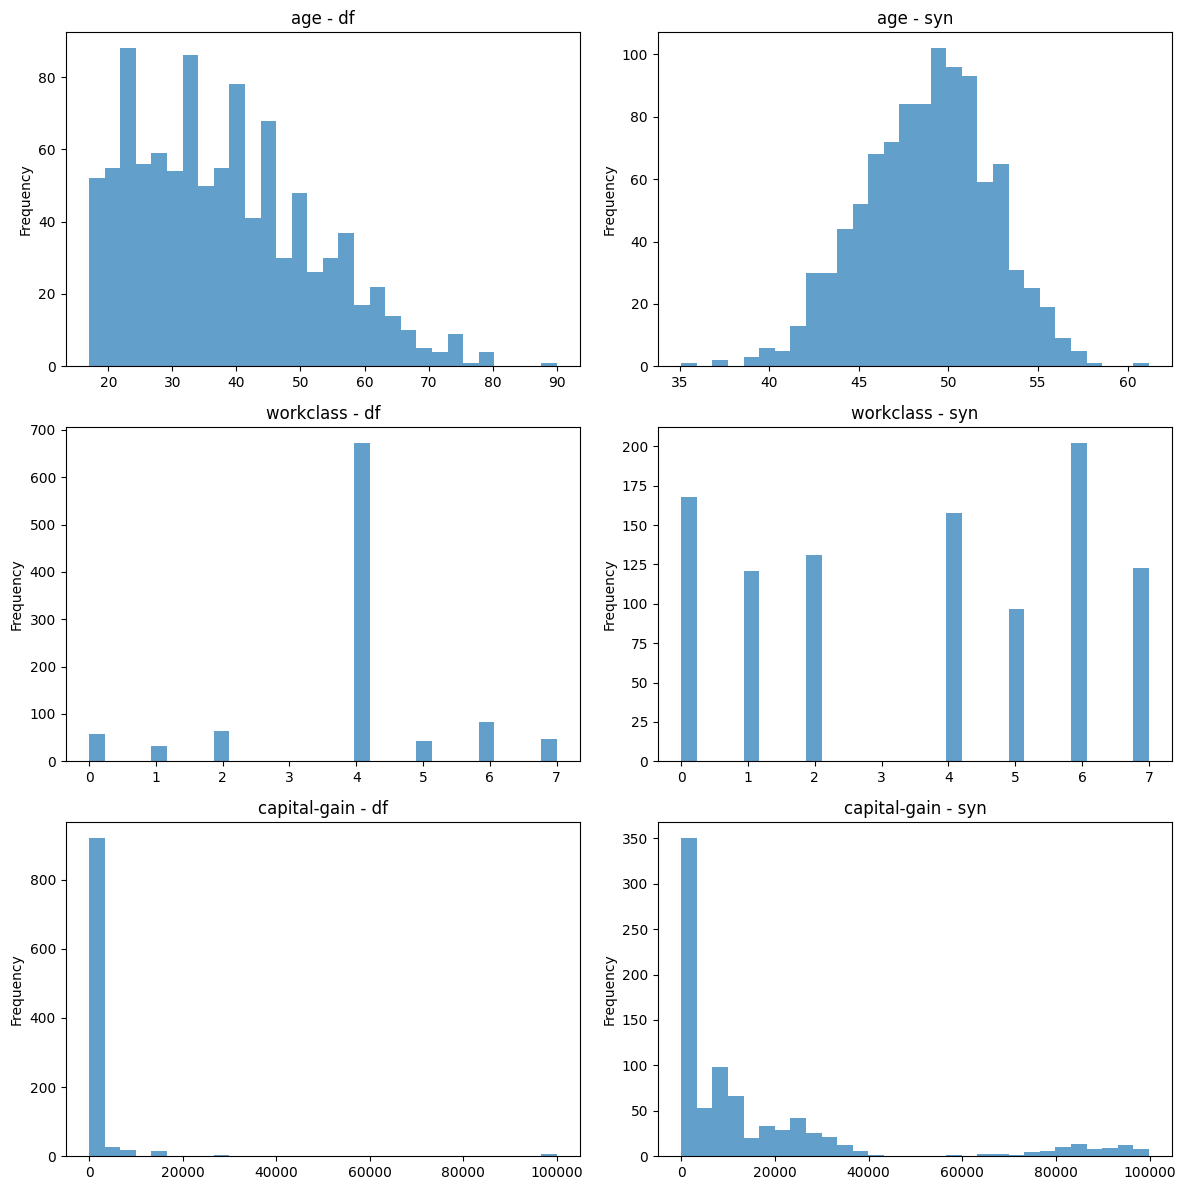

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

columns = df.columns

for i, column in enumerate(columns):
    df[column].plot(kind='hist', ax=axes[i, 0], title=f'{column} - df', bins=30, alpha=0.7)
    syn[column].plot(kind='hist', ax=axes[i, 1], title=f'{column} - syn', bins=30, alpha=0.7)

plt.tight_layout()
plt.show()